We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")


# Overview

In the following notebook we evaluate the Poincare map on the time-periodic version of the [Bickley jet](../../../../../2D/data/Bickley/Bickley.ipynb). Eventhough the Bickley jet is analytically well defined, the velocity field has been discretized over a gridded spatio-temporal domain. The notebook is structured as follows:

1. Import data from the file 'Bickley.mat' stored in the folder 'data'. Please first generate this 'mat-file' by running the following [script](../../../../../2D/data/Bickley/Bickley.ipynb)
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from the (discrete) gridded data.
 <br />
5. Poincare map:

    * Compute trajectories launched from a rectangular meshgrid over [0,1000$ \mathrm{T_{periodic}} $], where $ \mathrm{T_{periodic}}$ is the periodic period given in [Bickley](../../../../../2D/data/Bickley/Bickley.ipynb).
    
    <br />
    
    * Sample the trajectories at a regular time-intervals $ \mathrm{T_{periodic}}$.
 <br />
6. References   
 

# Import data

In [2]:
# import scipy
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Bickley/Bickley.mat')

U = mat_file['u'] # array (NY, NX, NT)
V = mat_file['v'] # array (NY, NX, NT)
x = mat_file['x'] # array (NY, NX)
y = mat_file['y'] # array (NY, NX)
time_data = mat_file['t'] # array (1, NT)

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 4 # int

# Time resolution of data
dt_data = time_data[0, 1]-time_data[0,0] # float

# Period
T_periodic = time_data[0,-1] # float

# Periodic boundary conditions
periodic_x = False # bool
periodic_y = False # bool
periodic_t = True # bool
periodic = [periodic_x, periodic_y, periodic_t] # list(3, )

# Unsteady velocity field
bool_unsteady = True # bool

# Defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int) # array (NY, NX)

## Compute meshgrid of dataset
X, Y = np.meshgrid(x, y) # array (NY, NX), array (NY, NX)

## Resolution of meshgrid
dx_data = X[0,1]-X[0,0] # float
dy_data = Y[1,0]-Y[0,0] # float

delta = [dx_data, dy_data] # list (2, )

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time (in days)
t0 = 0.0 # float

# Final time (in days)
tN = T_periodic # float

# periodic time-interval
Nt = 200 # int
time = np.linspace(t0, tN, Nt) # array (Nt,)

time_append = time.copy()

N_periodic_intervals = 1000 # int

for i in range(N_periodic_intervals-1):
    
    time = np.append(time, time[-1]+time_append[1:]) # array (N_periodic_intervals*(Nt-1)+1, )
    
time_poincare = time[::(Nt-1)] # array (N_periodic_intervals+1, )

# length of time interval (in days)
lenT = tN-t0 # float

# longitudinal and latitudinal boundaries (in degrees)
xmin = 0 # float
xmax = 20000 # float
ymin = -3000 # float
ymax = 3000 # float

# spacing of meshgrid (in degrees)
dx = 2*(X[0,1]-X[0,0]) # float 
dy = 2*(Y[1,0]-Y[0,0]) # float

x_domain = np.arange(xmin, xmax + dx, dx) # array (Nx,)
y_domain = np.arange(ymin, ymax + dy, dy) # array (Ny,)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain) # array (Ny, Nx)

# Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default is "cubic". 

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object

# Poincare map

The poincare map of the time-periodic Bickley-jet is constructed by stroboscopically sampling the trajectories at regular periodic time-intervals $ \mathrm{T_{periodic}} $. The trajectories are initially seeded over a rectangular meshgrid and advected over a period of $ [0, 1000T_{periodic}] $. Sampling the resulting trajectories at regular intervals $ \mathrm{T_{periodic}} $ leads to discretized trajectories. The poincare map requires a fairly small number of particles, but a very long integration time compared to other existing LCS diagnostics in order to converge.

## Compute trajectories

Here we compute trajectories launched from a rectangular meshgrid over the time-interval [0, 1000$ \mathrm{T_{periodic}} $]

In [6]:
# Import function to compute trajectories (=flow map)
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import package for parallel computing
from joblib import Parallel, delayed

# vectorize initial conditions
x0 = X_domain.ravel() # array (Nx*Ny, )
y0 = Y_domain.ravel() # array (Nx*Ny, )

# split x0, y0 into 'Ncores' batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny)

def parallel_Fmap(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch]) # array (2, Nx*Ny)
    
    # Compute trajectories
    Fmap = integration_dFdt(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[0] # array (Nt, 2, Nx*Ny)

    return Fmap

results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_Fmap)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

Fmap = results[0]

for res in results[1:]:
    Fmap = np.append(Fmap, res, axis = 2)

## Sample trajectories

We only retain the last 500 intersections of the trajectories with the timeslice given by $ \mathrm{t} \ \mathrm{mod} \ \mathrm{T_{periodic}} $.

In [9]:
# reshape to gridded domain
Fmap = Fmap.reshape((Fmap.shape[0], 2, X_domain.shape[0], X_domain.shape[1])) # array (Nt, 2, Ny, Nx)

# only keep last 500 intersections when discretized trajectories have converged
N_poincare = 500 # int

assert N_poincare > Nt, "N_poincare_samples must be bigger than Nt"

# discretize trajectories (=flow map)
Fmap_poincare = Fmap[::(Nt-1),:,:,:] # array (N_periodic_intervals+1, 2, Ny, Nx)
Fmap_poincare = Fmap_poincare[-N_poincare:,:,:,:] # array (N_poincare_samples, 2, Ny, Nx)

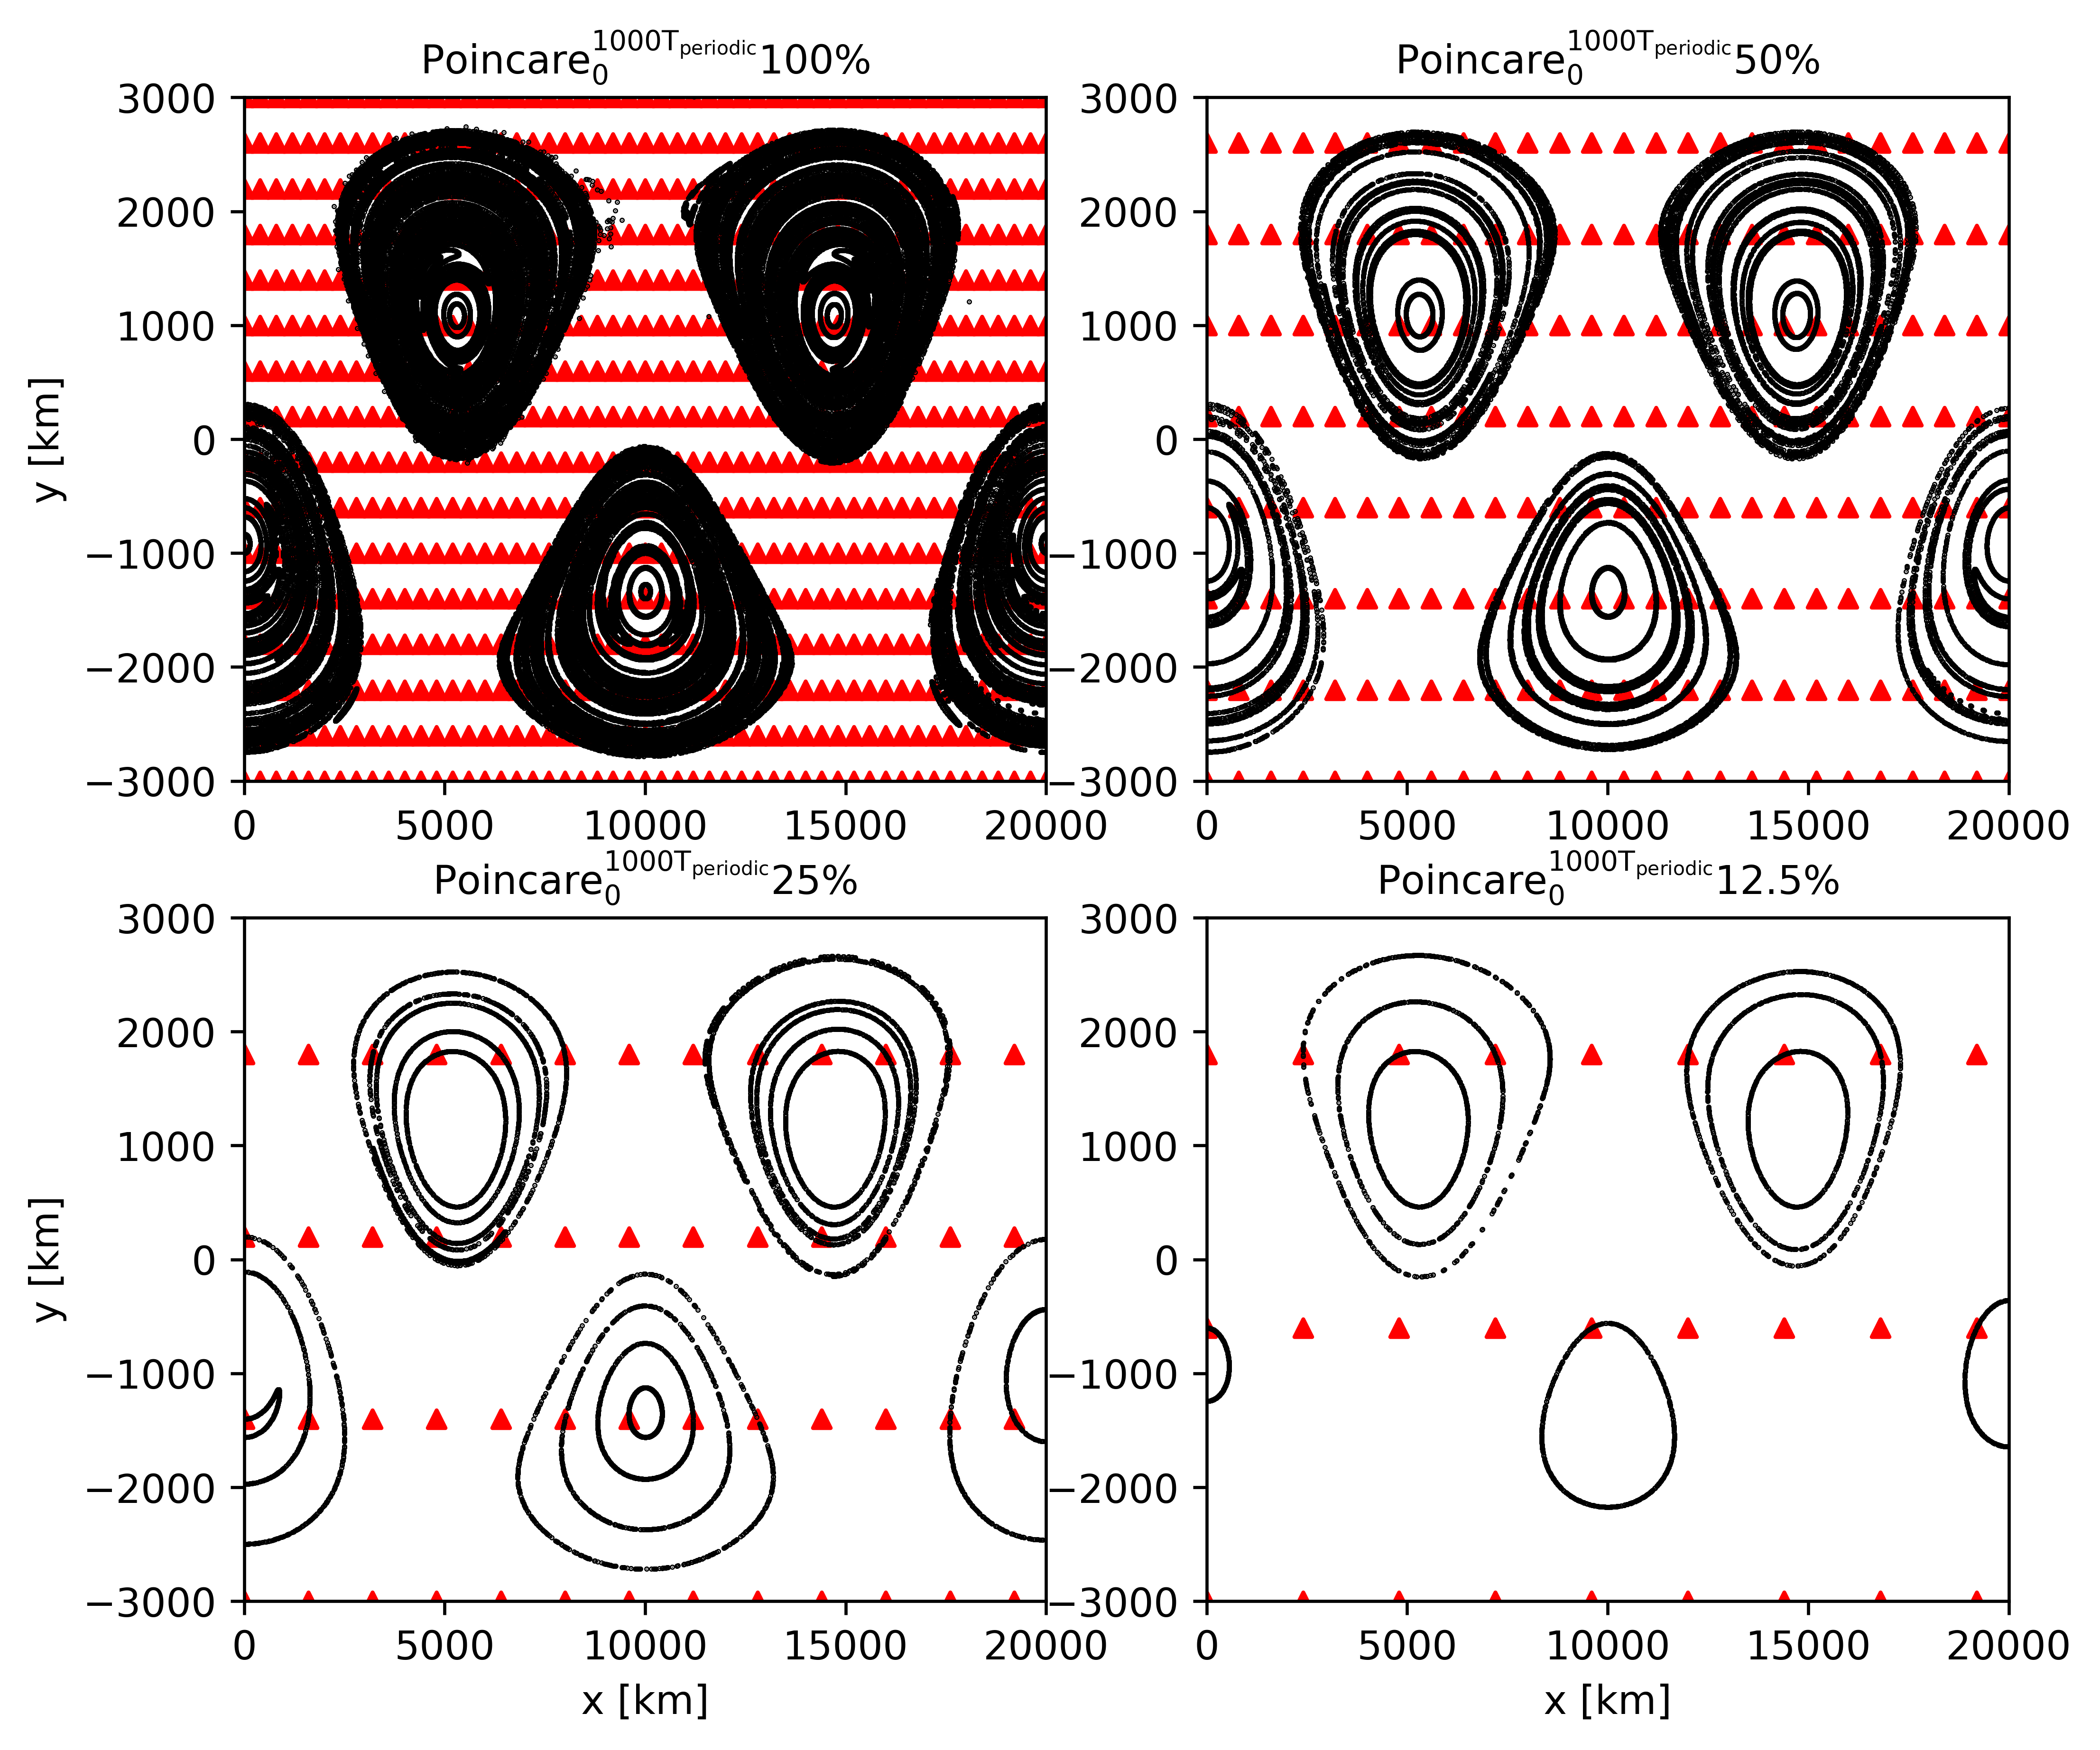

In [10]:
################################################ PLOT RESULTS ################################################

# Import plotting library
import matplotlib.pyplot as plt

# Figure/Axis
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, dpi = 600, figsize=(8, 7))

cax = ax0.scatter(Fmap[0, 0, :, :], Fmap[0, 1, :, :], s = 20, c = "r", marker = "^")
cax = ax0.scatter(Fmap_poincare[:, 0, :, :], Fmap_poincare[:, 1, :, :], s = 0.1, c = "k")

cax = ax1.scatter(Fmap[0, 0, ::2, ::2], Fmap[0, 1, ::2, ::2], s = 20, c = "r", marker = "^")
cax = ax1.scatter(Fmap_poincare[:, 0, ::2, ::2], Fmap_poincare[:, 1, ::2, ::2], s = 0.1, c = "k")

cax = ax2.scatter(Fmap[0, 0, ::4, ::4], Fmap[0, 1, ::4, ::4], s = 20, c = "r", marker = "^")
cax = ax2.scatter(Fmap_poincare[:, 0, ::4, ::4], Fmap_poincare[:, 1, ::4, ::4], s = 0.1, c = "k")

cax = ax3.scatter(Fmap[0, 0, ::6, ::6], Fmap[0, 1, ::6, ::6], s = 20, c = "r", marker = "^")
cax = ax3.scatter(Fmap_poincare[:, 0, ::6, ::6], Fmap_poincare[:, 1, ::6, ::6], s = 0.1, c = "k")

# Axis Labels
ax2.set_ylabel("y [km]", fontsize = 10)
ax2.set_xlabel("x [km]", fontsize = 10)
ax3.set_xlabel("x [km]", fontsize = 10)
ax0.set_ylabel("y [km]", fontsize = 10)

ax0.set_title(r'$ \mathrm{Poincare}_{0}^{1000\mathrm{T_{periodic}}} 100$%', fontsize = 10)
ax1.set_title(r'$ \mathrm{Poincare}_{0}^{1000\mathrm{T_{periodic}}} 50$%', fontsize = 10)
ax2.set_title(r'$ \mathrm{Poincare}_{0}^{1000\mathrm{T_{periodic}}} 25$%', fontsize = 10)
ax3.set_title(r'$ \mathrm{Poincare}_{0}^{1000\mathrm{T_{periodic}}} 12.5$%', fontsize = 10)

ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymin, ymax])
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymin, ymax])
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymin, ymax])
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymin, ymax])

plt.show()

The cloud of black dots indicates the discretized trajectories sampled at regular periodic time-intervals ($ \mathrm{T}_{periodic} $), The red triangles denote the initial position of the trajectories. Smooth curves indicate non-chaotic trajectories. The closed tori remain visible even under progressive downsampling.

# References

[1] Rypina, I. I., Brown, M. G., Beron-Vera, F. J., Koçak, H., Olascoaga, M. J., & Udovydchenkov, I. A. (2007). On the Lagrangian dynamics of atmospheric zonal jets and the permeability of the stratospheric polar vortex. Journal of the Atmospheric Sciences, 64(10), 3595-3610.

[2] del‐Castillo‐Negrete, D., & Morrison, P. J. (1993). Chaotic transport by Rossby waves in shear flow. Physics of Fluids A: Fluid Dynamics, 5(4), 948-965.

[3] Notebook 2.2.2 in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.